# Simulation of financial returns

Looking to see how a 'risky' investment will work, starting with a simple model that has good years and bad years, to simulate business cycles.

The first analysis is a simple expected value calculation to translate into an equivalent ARR

The second analysis plays this out, monte-carlo style over 10-20 years, and looking at the raw returns and comparing to expectations.  


In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# add data connection
import os
import gspread as gs
import pandas as pd
home_directory = os.path.expanduser("~")
goog_auth_file = "{}/secrets/modeling-general-data-a9fa2233aed5.json".format(home_directory)
gc = gs.service_account(filename=goog_auth_file)

In [3]:
# load parameters
spreadsheet_id ="12froVqa4mGoqglbnZyr_UY8CGl6Oxm_swMZyuh_YmdQ"
sheet = gc.open_by_key(spreadsheet_id)

## Utility Functions

In [37]:
def get_params_from_key(df, key):
    record = df.loc[df.id==key]
    assert(len(record)==1)  # should be 
    params = record.to_dict(orient='records')[0]
    return params

## Analysis 1, expected value, default

Using a 20% good return, and a 35% bad return that comes once in five years or so

In [58]:
# load sheet
worksheet = sheet.worksheet("general_setup")
setup_df = pd.DataFrame(worksheet.get_all_records())

In [59]:
# get case
key = 1
gparams = get_params_from_key(setup_df, key)

In [39]:
# assign params
goodret = gparams['good_year_return']
badret= gparams['bad_year_return']
prob= gparams['good_year_prob']


1.0899999999999999


In [ ]:
# compute and print
eret = prob*(1+goodret)+(1-prob)*(1+badret)

print(eret)

## Analysis 2, sweep of expected value with changing bad year


In [45]:
worksheet = sheet.worksheet("sweep_bad_year_severity")
sweep_df = pd.DataFrame(worksheet.get_all_records())

In [46]:
key = 's1'
sparams = get_params_from_key(sweep_df, key)

In [47]:
sparams

{'id': 's1',
 'min_bad_return': -0.9,
 'max_bad_return': 0.02,
 'resolution': 0.01}

In [49]:
# Sweep of max negative return

badret = np.arange(sparams['min_bad_return'], sparams['max_bad_return'], sparam['resolution'])
goodret = gparams['good_year_return']
prob= gparams['good_year_prob']

eret = prob*(1+goodret)+(1-prob)*(1+badret)


Text(0.5, 1.0, 'Model with 80.0% years with 1.2x gain')

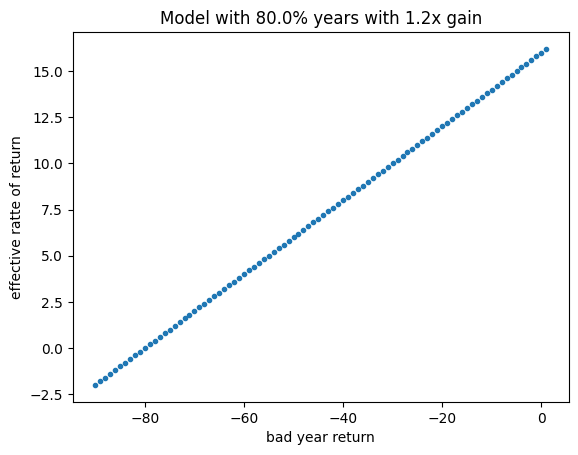

In [51]:
plt.plot(100*badret, 100*(eret-1), '.')
plt.xlabel('bad year return')
plt.ylabel('effective ratte of return')
plt.title('Model with {}% years with {}x gain'.format(100*prob, 1+goodret))

# Monte-Carlo trials

First compare effective RoR with the bad year return, at a given setpoint

In [74]:
worksheet = sheet.worksheet("mc_trials")
mc_df = pd.DataFrame(worksheet.get_all_records())

In [75]:
key = 'mc1'
mcparams = get_params_from_key(mc_df, key)

In [76]:
mcparams

{'id': 'mc1', 'N_trials': 4, 'N_years': 15}

In [77]:
from numpy.random import binomial, choice

In [78]:
# extract MC parameters
N = mcparams['N_years']
N_trials = mcparams['N_trials']

# general parameters
goodret = gparams['good_year_return']
badret = gparams['bad_year_return']
prob= gparams['good_year_prob']
altret1 = gparams['alt_return_fedfunds']+1
altret2 = gparams['alt_return_2']+1


In [79]:
# run expected simulation
periods = np.arange(0,N*12+1,1)
expret = prob*(1+goodret)+(1-prob)*(1+badret)

evalue = np.zeros(np.size(periods))
altvalue = np.zeros(np.size(periods))
altvalue2 = np.zeros(np.size(periods))

evalue[0] = 1.0
altvalue[0] =1.0
altvalue2[0] = 1.0
i=1
for m in range(12*N):
    evalue[i] = evalue[i-1]*(1+(expret-1)/12)
    altvalue[i] = altvalue[i-1]*(1+(altret1-1)/12)
    altvalue2[i] = altvalue2[i-1]*(1+(altret2-1)/12)
    i += 1



In [80]:
# run Ntrials simulations over good vs bad years

Ntrials = 4
value = np.zeros((Ntrials, N*12+1))
for n in range(Ntrials):
    yeartype = choice([True, False], size=(N,), p=[prob,1-prob])
    value[n,0] = 1.0
    i=1
    for y in yeartype:
        for m in range(12):
            if y:
                value[n,i] = value[n,i-1]*(1+goodret/12)
            else:
                value[n,i] = value[n,i-1]*(1+badret/12)
            i += 1



Text(0, 0.5, 'Total value')

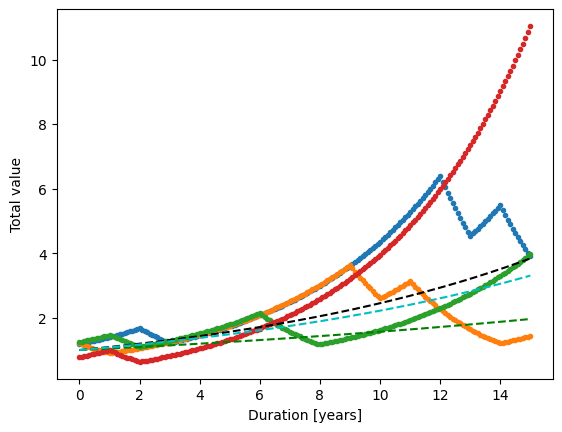

In [81]:
for n in range(Ntrials):
    plt.plot(periods/12, value[n,:]+np.random.rand()/2-0.25, '.')
plt.plot(periods/12, evalue, 'k--')

plt.plot(periods/12, altvalue, 'g--')
plt.plot(periods/12, altvalue2, 'c--')

plt.xlabel('Duration [years]')
plt.ylabel('Total value')




Text(0, 0.5, 'Rate of Return')

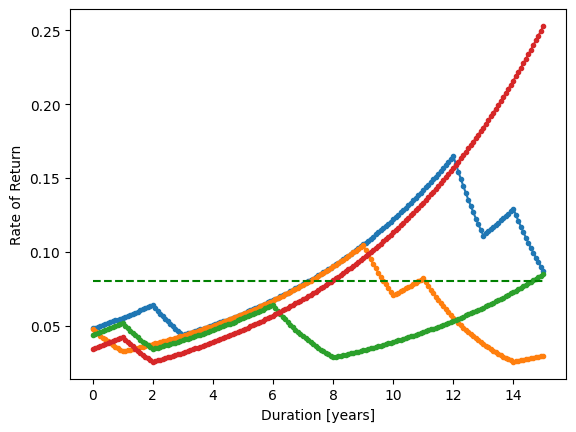

In [82]:
for n in range(Ntrials):
    plt.plot(periods/12, (altret1-1)*((value[n,:]+np.random.rand()/2-0.25)/altvalue), '.-')
plt.plot([0,N],[altret2-1,altret2-1], 'g--')
plt.xlabel('Duration [years]')
plt.ylabel('Rate of Return')


